# Part 2: Secondary Data Cleaning

### Objective 

**Make Stationary:** In this file, we will make some specific columns of the dataframe stationary (municipal green bonds, aggregate bonds, S&P500, energy index, nominal broad USD index, lithium, rare earths and crude oil). We are doing this, because the theory of these tree based methods required the underlying data to be iid. However, since we are working with time series, the data is obviously not iid. To bring the data closer to "iid", which is a much stronger condition than stationarity, we will still make the data stationary. The variables which are not made stationary in this data frame are SOFR, term spread, fed funds rate, eurocurrency volatility index, S&P500 volatility index, crude oil volatility, and gold volatility. This is because these data are directly interpretable from their level, and are generally interpreted this way by financial people. *Note:* Since we log difference or difference the data to make some columns stationary, we lose a single point of data on January 2nd, 2019.

**Normalize:** For the variables which we made stationary, we will normalize the data to be from -100 to 100. The range is chosen in order to make MSE more readable when we are interpreting the models (small MSE values are rounded to 0 when displayed by python).

**Partition:** Finally, we will partition the data into the "covid" and "post-covid" time frames. The "covid" time frame is now Jan 3rd, 2019 to May 31st, 2023. The "post-covid" time frame remains unchanged and is June 1st, 2023 to Dec 31st, 2024.

**Export Output:** We will export 3 different excel files. These are "covid", "post-covid" and "full". "full"  is just the "covid" and "post-covid" data sets added together.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.dates as mdates

## Display Graphs

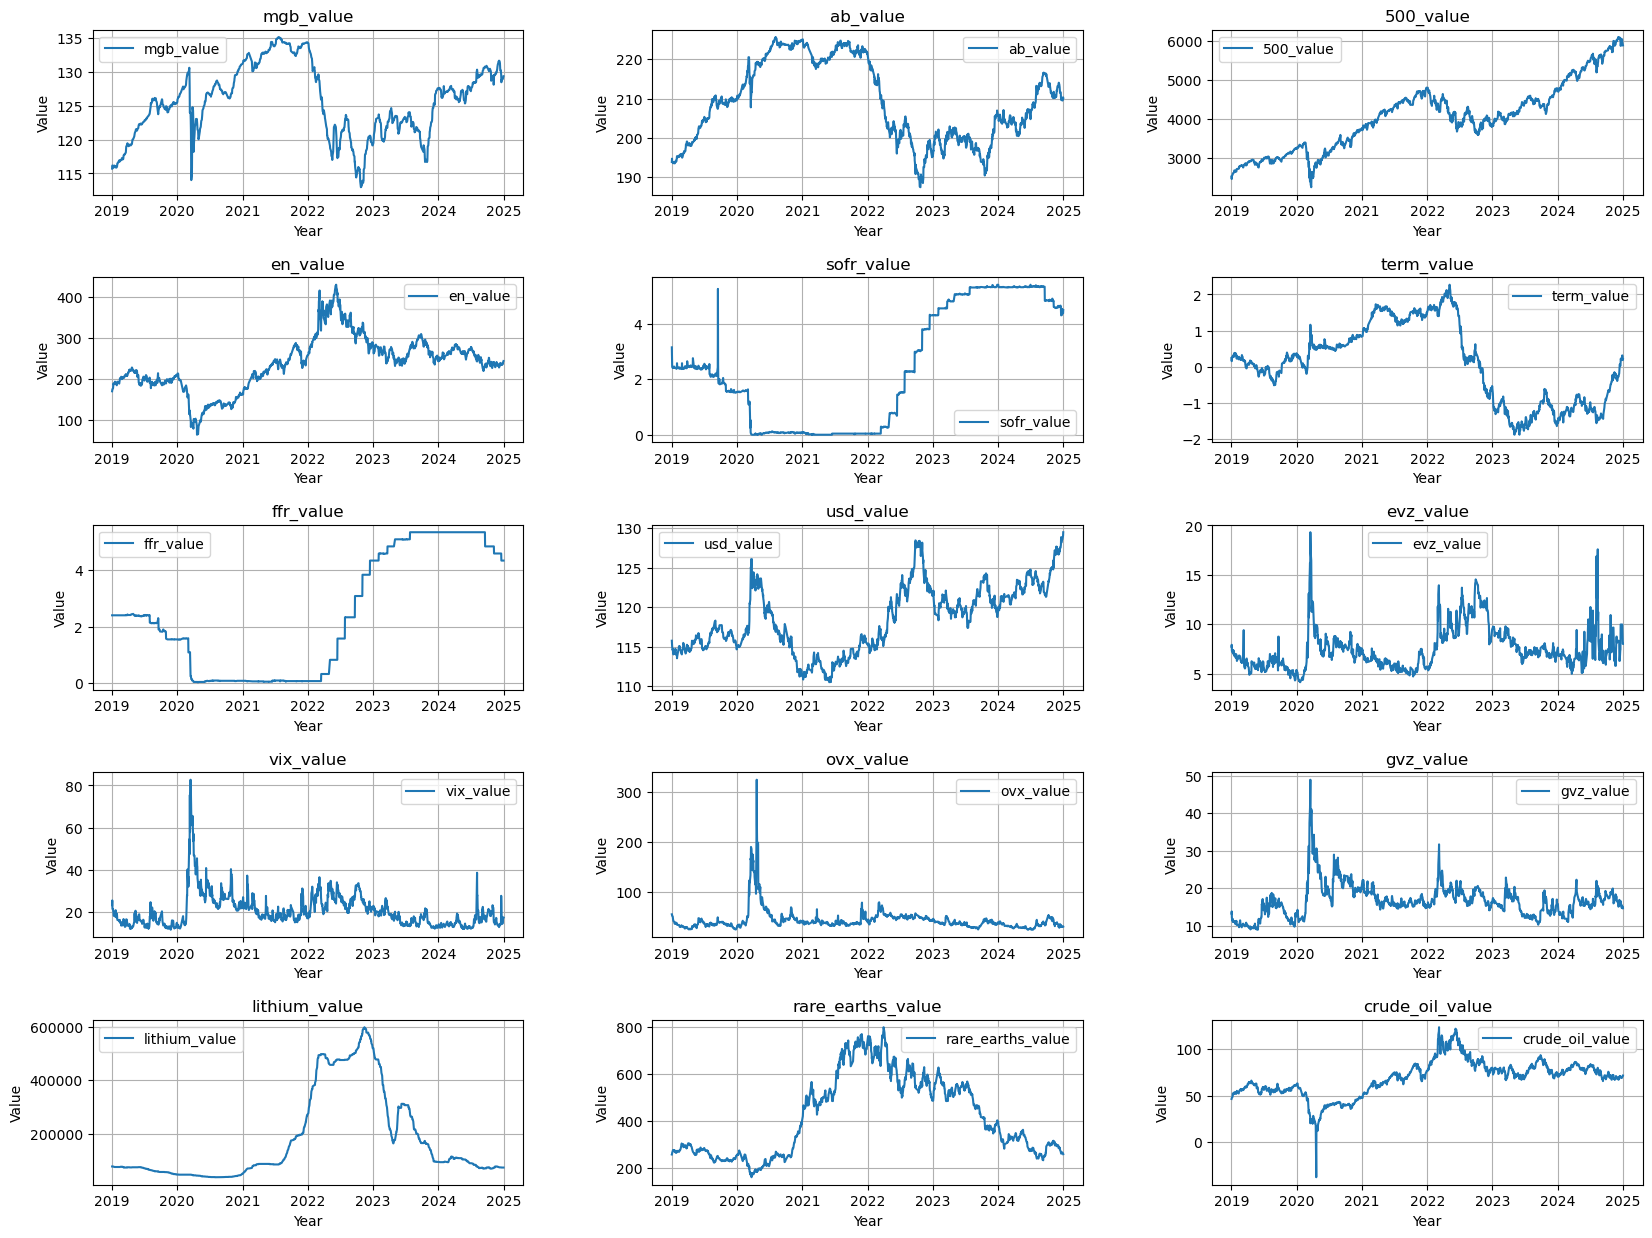

In [2]:
df_data = pd.read_excel("./cleaned_excel_data/full_data_first_round.xlsx")

# set date to index for better plotting
df_data.set_index('date', inplace=True)

# plot all the data
num_cols = df_data.shape[1]
n_cols = 3  # Number of columns per row
n_rows = (num_cols + n_cols - 1) // n_cols

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(df_data.columns):
    axes[i].plot(df_data.index, df_data[col], label=col)
    axes[i].set_title(col)
    axes[i].set_xlabel('Year')              
    axes[i].set_ylabel('Value')             
    axes[i].legend(loc='best')              
    axes[i].grid(True)
    
    # Format x-axis to show years
    axes[i].xaxis.set_major_locator(mdates.YearLocator())          # Tick every year
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as '2020', '2021', etc.

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
# plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

Since we know that in theory, Muncipal Green Bonds, Aggregate Bonds, S&P500, and Energy Index should follow a geometric brownian motion, we will take the log difference of that data. 

We will take the difference of lithium, rare earths, crude oil, and USD. I know ahead of time that differencing once is enough to make the data stationary.

It wouldn't make sense to make stationary the other data, because the information is either an interest rate or a volatility index. Those values are directly interpretable, so I would like to keep them as is.

## Show Data Not Stationary

We will run Augmented Dickey Fuller tests on the aformentioned data. Remember that $H_0$ is: the data is not stationary. $H_a$ is: the data is stationary. We want to see p values less than 0.05 so we can reject the null hypothesis of non-stationarity. 

#### ADF Test on Un-differenced Data

In [3]:
variables = {
    'mgb_value': 'Municipal Green Bonds',
    'ab_value': 'Aggregate Bonds', 
    '500_value': 'S&P 500',
    'en_value': 'Energy Index',
    'lithium_value': 'Lithium',
    'rare_earths_value': 'Rare Earths',
    'crude_oil_value': 'Crude Oil',
    'usd_value': 'USD'
}

adf_results = {}

print(f"{'Variable':<25} {'ADF Statistic':<15} {'p-value':<12} {'Stationary':<12}")

for col, name in variables.items():
    if col in df_data.columns:
        adf_result = adfuller(df_data[col])
        adf_stat = adf_result[0]
        p_value = adf_result[1]
        is_stationary = "Yes" if p_value < 0.05 else "No"
        
        # Store results for later use
        adf_results[col] = {
            'name': name,
            'adf_statistic': adf_stat,
            'p_value': p_value,
            'critical_values': adf_result[4],
            'is_stationary': is_stationary
        }
        
        print(f"{name:<25} {adf_stat:<15.4f} {p_value:<12.4f} {is_stationary:<12}")



Variable                  ADF Statistic   p-value      Stationary  
Municipal Green Bonds     -2.3816         0.1470       No          
Aggregate Bonds           -1.6639         0.4498       No          
S&P 500                   -0.5221         0.8876       No          
Energy Index              -1.4851         0.5409       No          
Lithium                   -1.7897         0.3856       No          
Rare Earths               -1.2642         0.6454       No          
Crude Oil                 -1.8880         0.3377       No          
USD                       -1.1556         0.6924       No          


We can see none of the above data is stationary. This is not surprising.

## Make Data Stationary

In [4]:
# take log diffed data
df_data['mgb_log_diff'] = np.log(df_data['mgb_value']).diff()
df_data['ab_log_diff'] = np.log(df_data['ab_value']).diff()
df_data['500_log_diff'] = np.log(df_data['500_value']).diff()
df_data['en_log_diff'] = np.log(df_data['en_value']).diff()

# take diffed data
df_data['lithium_diff'] = df_data['lithium_value'].diff()
df_data['rare_earths_diff'] = df_data['rare_earths_value'].diff()
df_data['crude_oil_diff'] = df_data['crude_oil_value'].diff()
df_data['usd_diff'] = df_data['usd_value'].diff()

# since we log diffed / diffed, we lose one data point on Jan 2nd, 2019. This is not too much of an issue.
df_data = df_data.dropna() # trim off the first day Jan 2nd, 2023 

In [5]:
df_data[['mgb_log_diff', 'ab_log_diff','500_log_diff','en_log_diff', 
         'lithium_diff', 'rare_earths_diff','crude_oil_diff', 'usd_diff' ]]

mgb_log_diff  ab_log_diff  500_log_diff  en_log_diff  \
date                                                               
2019-01-03      0.003881     0.004272     -0.025068     0.012238   
2019-01-04     -0.000172    -0.004014      0.033759     0.019308   
2019-01-07      0.000086    -0.000929      0.006986     0.006487   
2019-01-08     -0.001465    -0.000826      0.009649     0.021933   
2019-01-09     -0.001208     0.000620      0.004090     0.042155   
...                  ...          ...           ...          ...   
2024-12-24      0.000233     0.000811      0.010982     0.012665   
2024-12-26      0.000233     0.000620     -0.000406    -0.008666   
2024-12-27      0.000155    -0.001765     -0.011117     0.013662   
2024-12-30      0.002401     0.003906     -0.010760     0.016737   
2024-12-31      0.000773    -0.000856     -0.004294     0.002714   

            lithium_diff  rare_earths_diff  crude_oil_diff  usd_diff  
date                                                                  
2019-01-03           0.0              1.71            0.55   -0.3065  
2019-01-04           0.0              5.70            0.87   -0.4798  
2019-01-07           0.0              7.62            0.56   -0.4192  
2019-01-08        -500.0              1.35            1.26    0.1651  
2019-01-09           0.0              3.24            2.58   -0.5878  
...                  ...               ...             ...       ...  
2024-12-24           0.0              3.67            0.86    0.0295  
2024-12-26           0.0             -1.35           -0.48    0.0028  
2024-12-27           0.0             -0.50            0.98    0.1293  
2024-12-30           0.0             -2.98            0.39    0.3502  
2024-12-31           0.0             -3.17            0.73    0.4406  

[1366 rows x 8 columns]

#### ADF Test on Differenced Data

In [6]:
variables = {
    'mgb_log_diff': 'Log Diff Municipal Green Bonds',
    'ab_log_diff': 'Log Diff Aggregate Bonds', 
    '500_log_diff': 'Log Diff S&P 500',
    'en_log_diff': 'Log Diff Energy Index',
    'lithium_diff': 'Diff Lithium',
    'rare_earths_diff': 'Diff Rare Earths',
    'crude_oil_diff': 'Diff Crude Oil',
    'usd_diff': 'Diff USD'
}

adf_results = {}

print(f"{'Variable':<40} {'ADF Statistic':<15} {'p-value':<12} {'Stationary':<12}")

for col, name in variables.items():
    if col in df_data.columns:
        adf_result = adfuller(df_data[col])
        adf_stat = adf_result[0]
        p_value = adf_result[1]
        is_stationary = "Yes" if p_value < 0.05 else "No"
        
        # Store results for later use
        adf_results[col] = {
            'name': name,
            'adf_statistic': adf_stat,
            'p_value': p_value,
            'critical_values': adf_result[4],
            'is_stationary': is_stationary
        }
        
        print(f"{name:<40} {adf_stat:<15.4f} {p_value:<12.4f} {is_stationary:<12}")

Variable                                 ADF Statistic   p-value      Stationary  
Log Diff Municipal Green Bonds           -12.0593        0.0000       Yes         
Log Diff Aggregate Bonds                 -26.6512        0.0000       Yes         
Log Diff S&P 500                         -8.8680         0.0000       Yes         
Log Diff Energy Index                    -6.5998         0.0000       Yes         
Diff Lithium                             -4.6601         0.0001       Yes         
Diff Rare Earths                         -32.1106        0.0000       Yes         
Diff Crude Oil                           -8.8678         0.0000       Yes         
Diff USD                                 -9.4220         0.0000       Yes         


Now we can see all the p values are well below 0.05. So, the selected columns are now stationary.

## Display New Data

In [7]:
df_data.drop(columns=['mgb_value', 'ab_value', '500_value', 'en_value', 'lithium_value', 'rare_earths_value', 'crude_oil_value', 'usd_value'], inplace=True)

In [8]:
df_data

sofr_value  term_value  ffr_value  evz_value  vix_value  \
date                                                                  
2019-01-03        2.70        0.15       2.40       7.92      25.45   
2019-01-04        2.45        0.25       2.40       7.29      21.38   
2019-01-07        2.41        0.25       2.40       7.37      21.40   
2019-01-08        2.42        0.27       2.40       7.14      20.47   
2019-01-09        2.45        0.29       2.40       7.40      19.98   
...                ...         ...        ...        ...        ...   
2024-12-24        4.40        0.19       4.33       9.97      14.27   
2024-12-26        4.53        0.23       4.33       9.97      14.73   
2024-12-27        4.46        0.31       4.33       9.97      15.95   
2024-12-30        4.37        0.18       4.33       8.01      17.40   
2024-12-31        4.49        0.21       4.33       8.01      17.35   

            ovx_value  gvz_value  mgb_log_diff  ab_log_diff  500_log_diff  \
date                                                                        
2019-01-03      53.57      13.77      0.003881     0.004272     -0.025068   
2019-01-04      51.52      12.04     -0.000172    -0.004014      0.033759   
2019-01-07      50.42      11.66      0.000086    -0.000929      0.006986   
2019-01-08      46.08      11.16     -0.001465    -0.000826      0.009649   
2019-01-09      44.36      11.69     -0.001208     0.000620      0.004090   
...               ...        ...           ...          ...           ...   
2024-12-24      30.35      14.71      0.000233     0.000811      0.010982   
2024-12-26      30.01      15.19      0.000233     0.000620     -0.000406   
2024-12-27      30.21      14.67      0.000155    -0.001765     -0.011117   
2024-12-30      30.77      15.02      0.002401     0.003906     -0.010760   
2024-12-31      30.02      14.62      0.000773    -0.000856     -0.004294   

            en_log_diff  lithium_diff  rare_earths_diff  crude_oil_diff  \
date                                                                      
2019-01-03     0.012238           0.0              1.71            0.55   
2019-01-04     0.019308           0.0              5.70            0.87   
2019-01-07     0.006487           0.0              7.62            0.56   
2019-01-08     0.021933        -500.0              1.35            1.26   
2019-01-09     0.042155           0.0              3.24            2.58   
...                 ...           ...               ...             ...   
2024-12-24     0.012665           0.0              3.67            0.86   
2024-12-26    -0.008666           0.0             -1.35           -0.48   
2024-12-27     0.013662           0.0             -0.50            0.98   
2024-12-30     0.016737           0.0             -2.98            0.39   
2024-12-31     0.002714           0.0             -3.17            0.73   

            usd_diff  
date                  
2019-01-03   -0.3065  
2019-01-04   -0.4798  
2019-01-07   -0.4192  
2019-01-08    0.1651  
2019-01-09   -0.5878  
...              ...  
2024-12-24    0.0295  
2024-12-26    0.0028  
2024-12-27    0.1293  
2024-12-30    0.3502  
2024-12-31    0.4406  

[1366 rows x 15 columns]

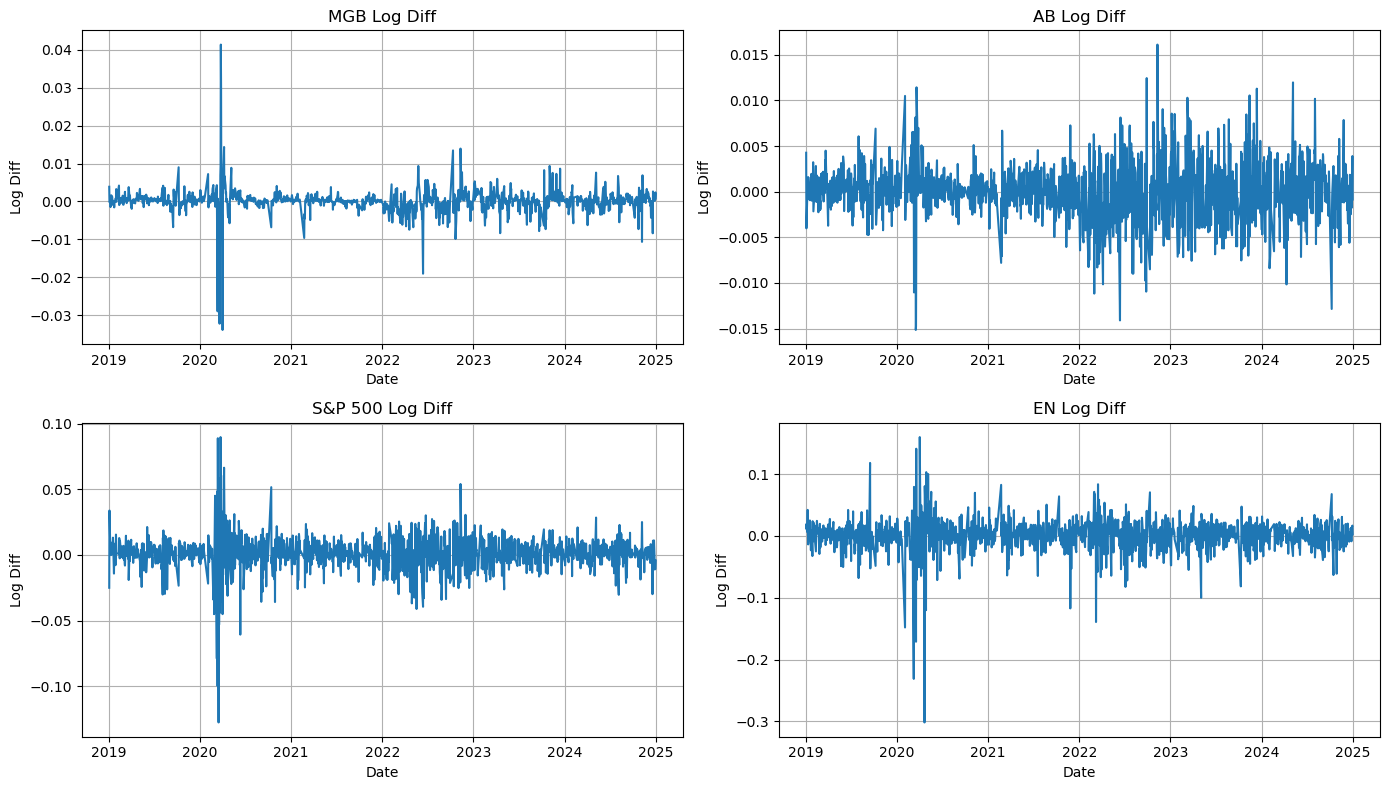

In [9]:
# let's print out the data
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  # flatten 2x2 grid into 1D array

# Define columns and titles
log_diff_cols = ['mgb_log_diff', 'ab_log_diff', '500_log_diff', 'en_log_diff']
titles = ['MGB Log Diff', 'AB Log Diff', 'S&P 500 Log Diff', 'EN Log Diff']

# Plot each log-differenced series
for i, col in enumerate(log_diff_cols):
    axes[i].plot(df_data.index, df_data[col])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Log Diff')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

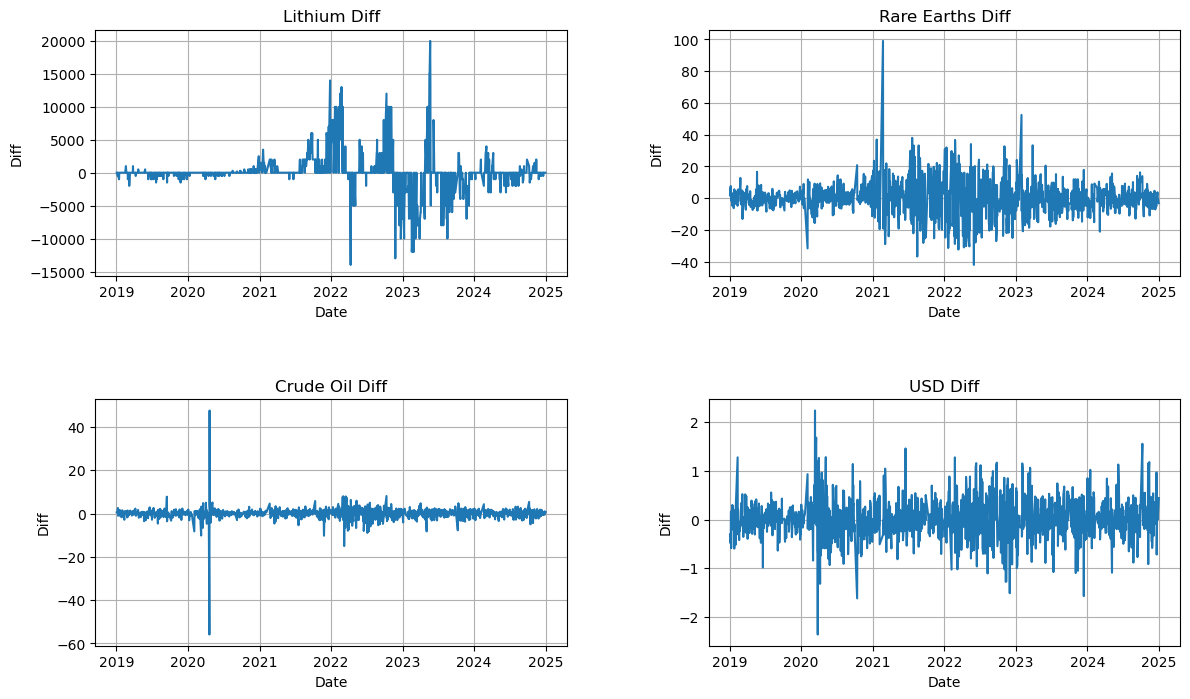

In [10]:
# let's print out the data
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  

# Define columns and titles
diff_cols = ['lithium_diff', 'rare_earths_diff', 'crude_oil_diff', 'usd_diff']
titles = ['Lithium Diff', 'Rare Earths Diff', 'Crude Oil Diff', 'USD Diff']

# Plot each log-differenced series
for i, col in enumerate(diff_cols):
    axes[i].plot(df_data.index, df_data[col])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Diff')
    axes[i].grid(True)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
# plt.tight_layout()
plt.show()

## Scale Stationary Data

In [11]:
cols_to_scale = ['mgb_log_diff', 'ab_log_diff', '500_log_diff', 'en_log_diff',
                'lithium_diff', 'rare_earths_diff', 'crude_oil_diff', 'usd_diff']

df_scaled = df_data.copy()

for col in cols_to_scale:
    min_val = df_scaled[col].min()
    max_val = df_scaled[col].max()
    df_scaled[col] = (2 * (df_scaled[col] - min_val) / (max_val - min_val) - 1) * 100 # normalize to be between -100 and 100

In [12]:
df_scaled

sofr_value  term_value  ffr_value  evz_value  vix_value  \
date                                                                  
2019-01-03        2.70        0.15       2.40       7.92      25.45   
2019-01-04        2.45        0.25       2.40       7.29      21.38   
2019-01-07        2.41        0.25       2.40       7.37      21.40   
2019-01-08        2.42        0.27       2.40       7.14      20.47   
2019-01-09        2.45        0.29       2.40       7.40      19.98   
...                ...         ...        ...        ...        ...   
2024-12-24        4.40        0.19       4.33       9.97      14.27   
2024-12-26        4.53        0.23       4.33       9.97      14.73   
2024-12-27        4.46        0.31       4.33       9.97      15.95   
2024-12-30        4.37        0.18       4.33       8.01      17.40   
2024-12-31        4.49        0.21       4.33       8.01      17.35   

            ovx_value  gvz_value  mgb_log_diff  ab_log_diff  500_log_diff  \
date                                                                        
2019-01-03      53.57      13.77      0.358588    24.212697     -5.598524   
2019-01-04      51.52      12.04    -10.425461   -28.784170     48.536865   
2019-01-07      50.42      11.66     -9.738328    -9.049760     23.898988   
2019-01-08      46.08      11.16    -13.863927    -8.394462     26.349232   
2019-01-09      44.36      11.69    -13.180591     0.853100     21.233683   
...               ...        ...           ...          ...           ...   
2024-12-24      30.35      14.71     -9.348097     2.076174     27.576459   
2024-12-26      30.01      15.19     -9.348241     0.852974     17.096885   
2024-12-27      30.21      14.67     -9.554700   -14.397133      7.239678   
2024-12-30      30.77      15.02     -3.579031    21.876735      7.568768   
2024-12-31      30.02      14.62     -7.909889    -8.586994     13.518739   

            en_log_diff  lithium_diff  rare_earths_diff  crude_oil_diff  \
date                                                                      
2019-01-03    36.028057    -17.647059        -37.937385        9.039985   
2019-01-04    39.090996    -17.647059        -32.285026        9.658103   
2019-01-07    33.536666    -17.647059        -29.565094        9.059301   
2019-01-08    40.228074    -20.588235        -38.447372       10.411435   
2019-01-09    48.987923    -17.647059        -35.769939       12.961174   
...                 ...           ...               ...             ...   
2024-12-24    36.212944    -17.647059        -35.160788        9.638787   
2024-12-26    26.972841    -17.647059        -42.272277        7.050415   
2024-12-27    36.644971    -17.647059        -41.068140        9.870581   
2024-12-30    37.976923    -17.647059        -44.581385        8.730925   
2024-12-31    31.902659    -17.647059        -44.850545        9.387676   

             usd_diff  
date                   
2019-01-03 -10.654027  
2019-01-04 -18.190120  
2019-01-07 -15.554879  
2019-01-08   9.853888  
2019-01-09 -22.886589  
...               ...  
2024-12-24   3.957210  
2024-12-26   2.796138  
2024-12-27   8.297095  
2024-12-30  17.903114  
2024-12-31  21.834232  

[1366 rows x 15 columns]

#### Display Scaled Graphs

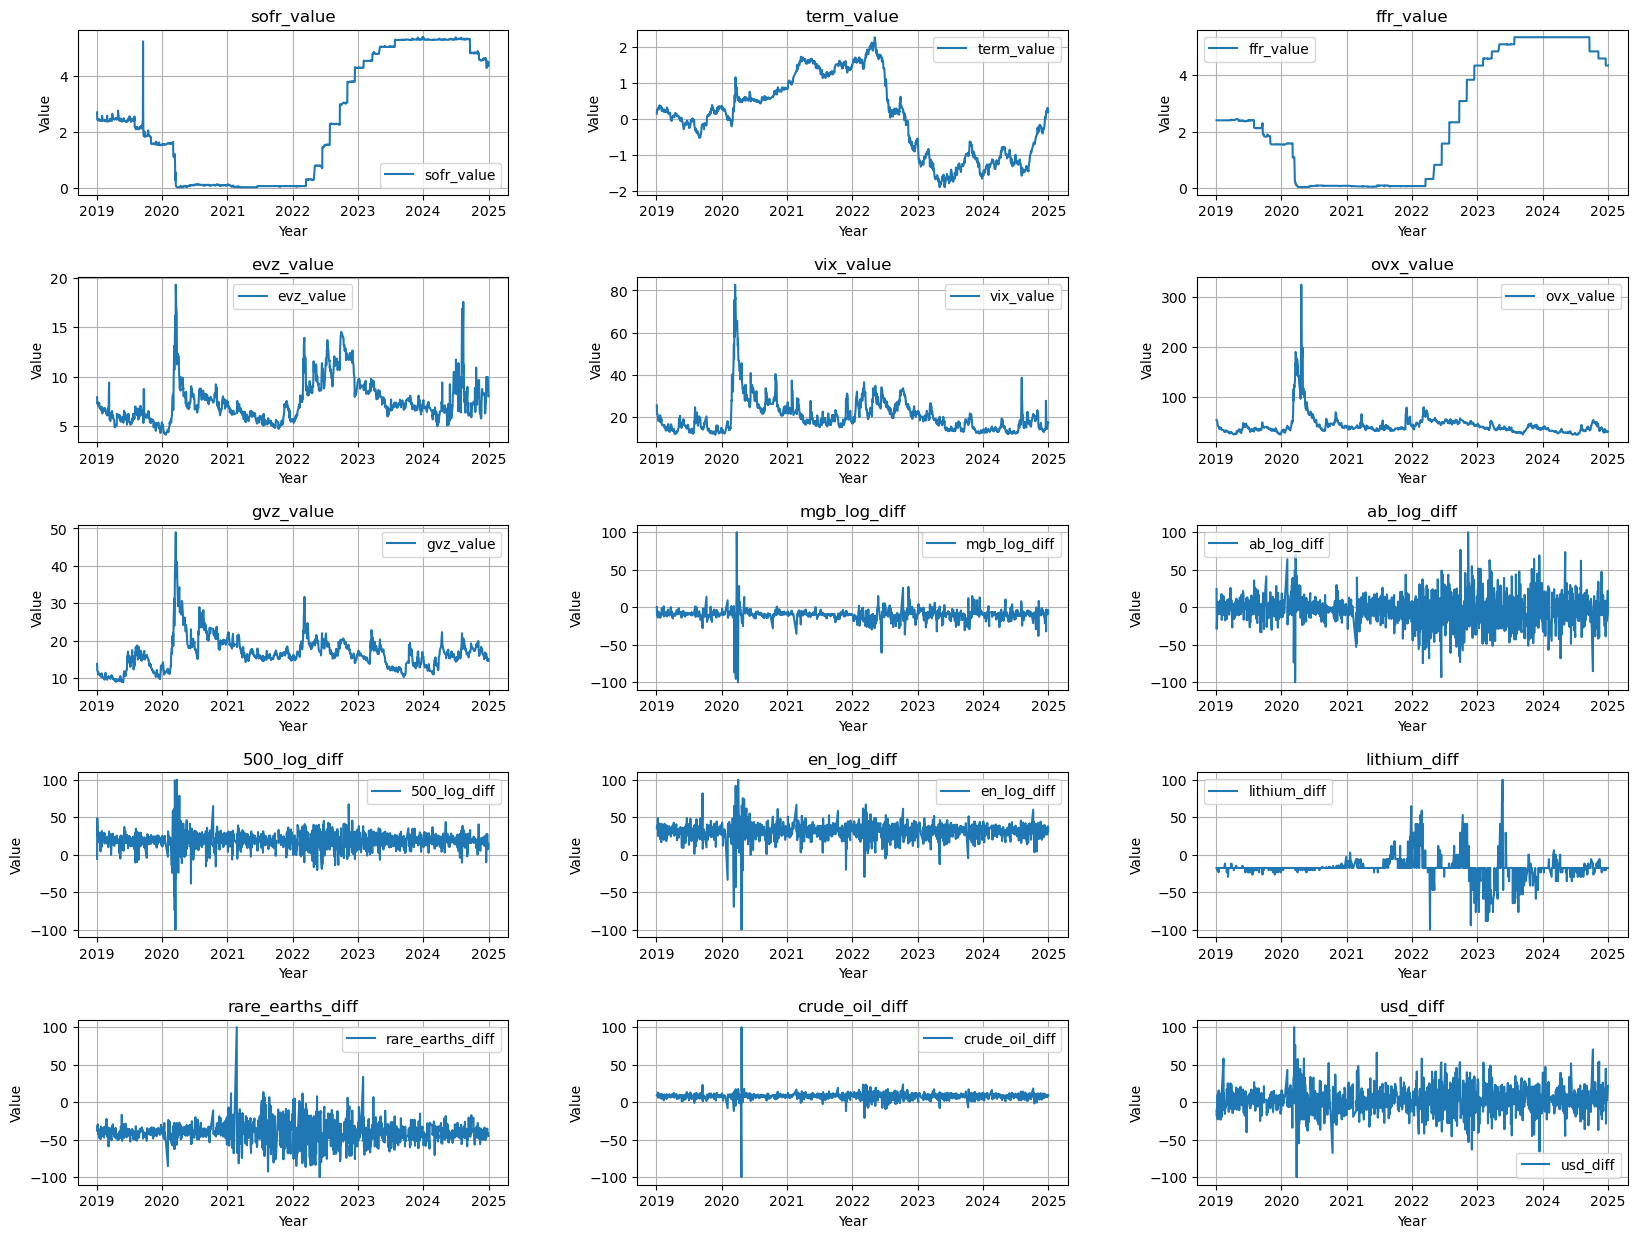

In [13]:
# let's print everything one last time
# plot all the data
num_cols = df_scaled.shape[1]
n_cols = 3  # Number of columns per row
n_rows = (num_cols + n_cols - 1) // n_cols

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(df_scaled.columns):
    axes[i].plot(df_scaled.index, df_scaled[col], label=col)
    axes[i].set_title(col)
    axes[i].set_xlabel('Year')              
    axes[i].set_ylabel('Value')             
    axes[i].legend(loc='best')              
    axes[i].grid(True)
    
    # Format x-axis to show years
    axes[i].xaxis.set_major_locator(mdates.YearLocator())          # Tick every year
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as '2020', '2021', etc.

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])



# plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

## Partition and Export the Data

In [14]:
df_covid = df_scaled.loc['2019-01-03':'2023-05-31']
df_post_covid = df_scaled.loc['2023-06-01':'2024-12-31']
df_covid.to_excel("./cleaned_excel_data/covid_data.xlsx")
df_post_covid.to_excel("./cleaned_excel_data/post_covid_data.xlsx")
df_scaled.to_excel("./cleaned_excel_data/full_data.xlsx")

## Extra: Correlation Heatmap

<Axes: >

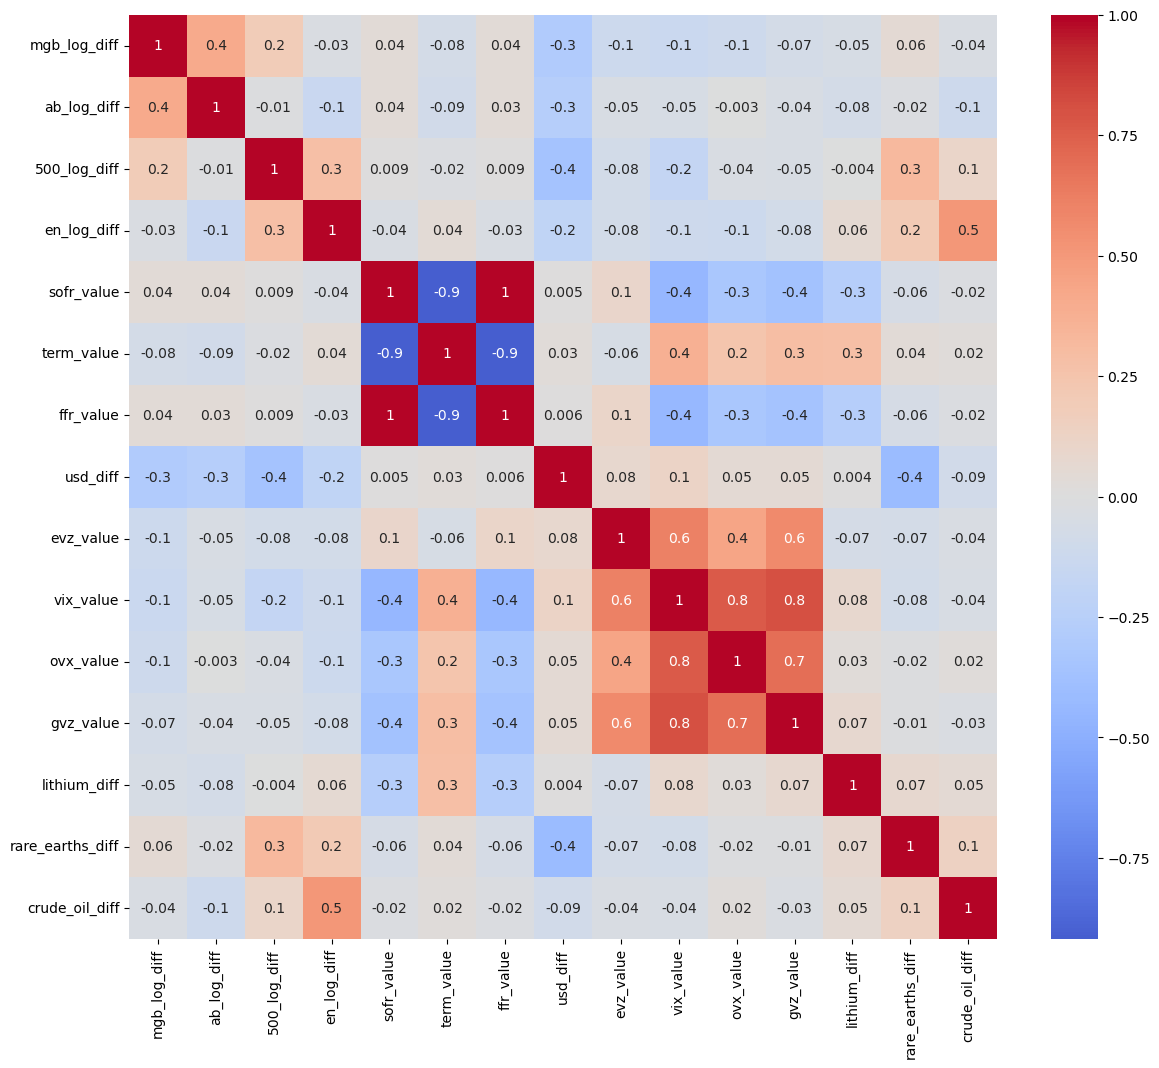

In [15]:
# correlation heatmap

cont = ['mgb_log_diff', 'ab_log_diff', '500_log_diff', 
        'en_log_diff','sofr_value', 'term_value', 
        'ffr_value', 'usd_diff', 'evz_value', 
        'vix_value', 'ovx_value', 'gvz_value', 
        'lithium_diff', 'rare_earths_diff', 'crude_oil_diff' ]

corr_matrix = pd.DataFrame(df_scaled[cont], columns = cont).corr()

plt.figure(figsize=(14, 12))

sns.heatmap(corr_matrix, 
            cmap = 'coolwarm',
            center = 0,
            annot = True,
            fmt = '.1g') # 1 not "l"